In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import pymc as mc
from matplotlib import animation

import numpy as np
import seaborn as sns
from scipy.integrate import odeint
from IPython.html.widgets import interact, fixed

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

:0: FutureWarning: IPython widgets are experimental and may change in the future.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



## Abstract

This notebook contains a mathematical description of the collision of two galaxies, one with several orbiting stars, as described by classical mechanics. The motion will be plotted at several values of time starting from some set of initial conditions. The situations modelled will be as followd: one case of retrograde passage and one case of direct passage. To model these a set of differential equations is defined and solved using Python's "odeint" solver. The solutions are the position and velocities of the distrupting galaxy and stars, which are saved into an array. To verify the correctness of the solution, the energy is plotted as a function of time to ensure that energy is conserved. 

## Base Question

The base question that this notebook explores is the mechanics of direct or retrograde passage of two massive point particles (galaxies). The difference between these two situations is the relative spin of the stars on the initial galaxy and the velocity of the disrupting galaxy. Retrograde passage is the case where the stars spin in a direction opposite to the motion of the disrupting galaxy, whilst direct passage has these velocities in the same orientation. In both cases the disrupting galaxy acts on the stars as well as the initial galaxy, disrupting their motions. The task is to plot the motion of all these bodies, and as a check, their energies. If energy is conserved, and the two galaxies are shown to interact, then it is concluded that the code accurately describes the interaction between two massie galaxies.

## Additional Questions

Additionally, this notebook will explore specific cases of direct passage of a light mass disruptor in an elliptical orbit and, secondly, retrograde passage of heavy mass disruptor in a parabolic orbit.

## Equations of Motion

$$ \ddot{\mathbf{r}} = -\gamma \left\{ \frac{M}{r^3}\mathbf{r} -\frac{S}{\rho^3}\boldsymbol{\rho} + \frac{S}{R^3}\boldsymbol\Re \right\} $$

$$ \ddot{\boldsymbol\Re} = -\gamma \frac{M+S}{R^3}\boldsymbol\Re$$

where 

* $\gamma$ is the Gravitational constant.
* $M$ is the central mass of the main galaxy and $S$ is the central mass of the disrupting galaxy
* $\mathbf{r}$ is the radius vector from mass $M$ to massless point particle $m$, representing a single (massless) star in the outer disk of the main galaxy.
* $\boldsymbol\Re$ is the radius vector from $M$ to $S$
* $\boldsymbol{\rho} = \boldsymbol{\Re} - \boldsymbol{r}$

In [2]:
Direct = 1
parabolic = 1

if parabolic != 1:
    epsilon = 0.2
    
gamma = 4.49933e4 #units of (kpc^3) / (M_sun^10)(years^9)^2    Derived by James Amarel

# M and S are the masses of the central galaxy and disrupting galaxy
if parabolic == 1:
    M = 1
    S = 10
else:
    M = 5
    S = 10

# atol and rtol are the error tolerances for the odeint solver.
atol,rtol = 1e-6,1e-6

#Disrupting Galaxy S initial position in y
if parabolic == 1:
    Sy = 75
else:
    Sy = 30*(1+epsilon)
# tmax is the maximum time the simulation will run to.
# t is a numpy array with equally spaced values of time starting from 0 and enting at tmax.

if parabolic == 1:
    tmax = 1.0
else:
    tmax = 5.0
t = np.linspace(0,tmax,1000)

## Velocity for a Circular Orbit

$$ v = \sqrt\frac{\gamma M}{r} $$

$ \gamma $ : The gravitational constant 

M : The mass of the central galaxy 

r : the radial distance of the star to the galaxy

## Star Initial Conditions

The below functions, ShellFill and makeN(), makes N stars in circular orbits for every iteration of ShellFill. It then returns an array with individual entires of the form [x,dx,y,dy]. This final array will be the initial conditions for the stars and will have 120 entries (corresponding to 120 stars).

In [3]:
def ShellFill(number,radius,Direct):
    ic = []
    thetastep = 2*np.pi/number
    theta = np.arange(0,2*np.pi,thetastep)
    s = [np.sin(k) for k in theta]
    c = [np.cos(k) for k in theta]
    if Direct == 1:
        v = np.sqrt(gamma*M/radius)
    else:
        v = -np.sqrt(gamma*M/radius)
    for i in range(len(theta)):
        newic = [radius*s[i],v*c[i],radius*c[i],-v*s[i]]
        ic.append(newic)
    return ic

In [4]:
def makeN():  
    """
    r0: A base radius to start the stars at.
    thetastep, theta: These are the step size, defined by number of stars, and angular position
                    of the stars. Note how the stars are set up to have equally spaced angles.
    ic: The array of initial conditions for the positions and velocities of the stars:
            of the form [[x1,dx1,y1,dy1],[x2,dx2,y2,dy2]...[xf,dxf,yf,dyf]] for N*shells stars.

    The paper has radii [0.2,0.3,0.4,0.5,0.6]*rmin, with [12,18,24,30,36] stars at each level
    """
    r0 = 25
    N = np.array([12,18,24,30,36])
    shells = np.array([0.20,0.30,0.40,0.50,0.60])*r0
    ic = []
    
    I = list(zip(N,shells))
    for i in I:
        newic = ShellFill(i[0],i[1],Direct)
        for i in newic:
            ic.append(i)
    return ic

## Velocity for a Parabolic Orbit

$$ v = \sqrt\frac{2\gamma (M+S)}{r} $$

$ \gamma $ : The gravitational constant 

M : The mass of the central galaxy 

r : the radial distance of the star to the galaxy

#Initial Conditions for Parabolic Passage

In [5]:
def parab(y):
    rmin = 25
    x = rmin - (y**2)/(4*rmin)
    R = np.sqrt(x**2 + y**2)
    v = np.sqrt(2*gamma*(M+S)/R)
    angle = np.arctan(50/y)
    if y == 0:
        vx,vy = 0,-v
    else:
        vy = -v*np.sin(angle)
        vx = v*np.cos(angle)
    return [x,vx,y,vy]

#Velocity for Elliptic Passage

$$ v = \sqrt{\gamma (M+S)(\frac{2}{r} - \frac{1}{a})} $$

$ \gamma $ : The gravitational constant 

M : The mass of the central galaxy 

r : the radial distance of the star to the galaxy

a : the semi-major axis

In [6]:
def ellip(y,epsilon):
    
    rmin = 30
    c = rmin*(1+epsilon)
    a = c/(1-epsilon**2)
    b = c/np.sqrt(1 - epsilon**2)
    d = a*epsilon
    x = d - a*np.sqrt(-(y**2)/(b**2) + 1)
    R = np.sqrt(x**2 + y**2)
    v = np.sqrt(gamma*(M+S)*((2/R)-(1/a)))
    angle = np.arctan(-(1/a*y)*np.sqrt((-(y**2)/(b**2)) + 1))
    
    vy = -v*np.sin(angle)
    vx = v*np.cos(angle)

    return [x,vx,y,vy]

## Disrupting Galaxy Initial Conditions

Galaxy() creates the initial conditions for the disrupting galaxy and appends them onto the end of EACH INITIAL CONDITION from the stars of the previous ic. To clarify, the resulting ic array will be an array of 12 arrays of size 8. This final ic will have the form of rvec as previously defined in derivs: rvec = [x,dx,y,dy,X,dX,Y,dY]

In [7]:
def Galaxy(parabolic):
    """
    X,Y: The relative X and Y positions of the disrupting galaxy to the central galaxy.
    R: The relative distance of the disrupting galaxy to the central galaxy.
    Vs: The velocity of the disrupting galaxy
    Sinfo: The array of positions, velocities of the disrupting galaxy: [x,dx,y,dy]
    """
    if parabolic == 1:
        Sinfo = parab(Sy)
    else:
        Sinfo = ellip(Sy,epsilon)
    # calls makeN() to pull the initial conditions for the stars to ic
    ic = makeN()
    # this for loop pulls open each array in ic (for each individual star) and appends to it the
    # initial conditions for the galaxy S, Sinfo.
    for i in ic:
        for j in range(len(Sinfo)):
            i.append(Sinfo[j])
    ic = np.array(ic)
    return ic

#Derivs Function

All motion is plotted as motion relative to this galaxy, and all positions are taken to be distances from this galaxy.

The below cell defines the derivs function that will be used by odeint to solve the system. It returns an array of the time derivatives of position and velocity, in the x and y directions, for a single star and disrupting galaxy.

In [8]:
def derivs(rvec,t):
    """
    rvec = [x,dx,y,dy,X,dX,Y,dY]
    
    x:  x component of relative position of single star to central galaxy.
    dx: x component of relative velocity of single star to central galaxy.
    y:  y component of relative position of single star to central galaxy.
    dy: y component of relative velocity of single star to central galaxy.
    
    X:  x component of relative position of disrupting galaxy to central galaxy.
    dX: x component of relative velocity of disrupting galaxy to central galaxy.
    Y:  y component of relative position of disrupting galaxy to central galaxy.
    dY: y component of relative velocity of disrupting galaxy to central galaxy.
    """
    
    x,y,X,Y = rvec[0],rvec[2],rvec[4],rvec[6]   
    dx,dy,dX,dY = rvec[1],rvec[3],rvec[5],rvec[7]
    
    """
    r: The radial distance from the single star to the central galaxy.
    R: The radial distance from the central galaxy to the disrupting galaxy.
    """
    r = np.sqrt(x**2 + y**2)
    R = np.sqrt(X**2 + Y**2)
    
    """
    ddx,ddy: The x and y components of the radial acceleration of the single star, respectively.
    ddX,ddY: The X and Y components of the radial acceleration of the disrupting galaxy, respectively.
    """
    
    ddx = -gamma*((M/(r**3))*x - (S/(np.sqrt((X-x)**2 + (Y-y)**2))**3)*(X-x) + (S/(R**3)*X))
    ddy = -gamma*((M/(r**3))*y - (S/(np.sqrt((X-x)**2 + (Y-y)**2))**3)*(Y-y) + (S/(R**3)*Y))
    
    ddX = -gamma*((M+S)/(R**3))*X
    ddY = -gamma*((M+S)/(R**3))*Y
                  
    return np.array([dx,ddx,dy,ddy,dX,ddX,dY,ddY])

#Get Solution

get_solution returns the array of positions and velocities for all the stars and disrupting galaxy for the initial conditions given by ic.

In [9]:
def get_solution():
    ic = Galaxy(parabolic)
    #these are the x and y positions/velocities for all the stars
    x,dx,y,dy = [],[],[],[]
    for k in range(len(ic)):
        soln = odeint(derivs,ic[k],t,atol=atol,rtol=rtol)
        x.append(np.array([j[0] for j in soln]))
        y.append(np.array([j[2] for j in soln]))     
        dx.append(np.array([j[1] for j in soln]))
        dy.append(np.array([j[3] for j in soln]))
    
    # note how the initial conditions for the disrupting galaxy can be defined for any iteration
    # as you iterate through k, soln is left with the last value, but the Sinfo components are the same
    #the following are the X and Y position/velocities of the disrupting galaxy
    X = np.array([j[4] for j in soln])
    Y = np.array([j[6] for j in soln])  
    dX = np.array([j[5] for j in soln])
    dY = np.array([j[7] for j in soln])
    
    return x,dx,y,dy,X,dX,Y,dY

#assign solutions to a giant array. Pass this to plot_motion(see below).
soln = get_solution();
if parabolic == 1:
    if Direct == 1:
        np.savez("ParabDirect", x= soln[0],dx = soln[1], y = soln[2],dy = soln[3],X = soln[4],dX = soln[5],Y = soln[6],dY = soln[7])
    else:
        np.savez("ParabRetro", x= soln[0],dx = soln[1], y = soln[2],dy = soln[3],X = soln[4],dX = soln[5],Y = soln[6],dY = soln[7])
else:
    if Direct == 1:
        np.savez("EllipDirect", x= soln[0],dx = soln[1], y = soln[2],dy = soln[3],X = soln[4],dX = soln[5],Y = soln[6],dY = soln[7])
    else:
        np.savez("EllipRetro", x= soln[0],dx = soln[1], y = soln[2],dy = soln[3],X = soln[4],dX = soln[5],Y = soln[6],dY = soln[7])

plot_motion assigns the solution values and plots them at a specified value of time (denoted by the index i). i=0 is passed as a default parameter to start at t = 0. 

#Plots Motion Relative to Central Galaxy

In [3]:
plt.ioff()
x,dx,y,dy,X,dX,Y,dY = get_solution()

fig_mpl, ax = plt.subplots(1,figsize=(8,8), facecolor='white');
plt.xlim(-75,75);
plt.ylim(-75,75);
plt.sca(ax);
ax.set_xlabel("X Position (kpc)");
ax.set_ylabel("Y Position (kpc)");
plt.title("Relative Motion");
plt.legend()

scat = ax.scatter(X[0],Y[0],color='red',label='Disrupting Galaxy, Mass S',s=10);
scatt = ax.scatter(x,y,color='green',s=5);
scattt = ax.scatter(0,0,color='black',label='Central Galaxy, Mass M',s=10);


def make_gif(u):
    newX,newY = X[u*40],Y[u*40]
    scat.set_offsets(np.transpose(np.vstack([newX,newY])))
    newx=[x[k][u*40] for k in range(120)]
    newy=[y[k][u*40] for k in range(120)]
    scatt.set_offsets(np.transpose(np.vstack([newx,newy])))
    return mplfig_to_npimage(fig_mpl)
if parabolic == 1:
    animation = mpy.VideoClip(make_gif,duration=tmax*25);
else:
    animation = mpy.VideoClip(make_gif,duration=tmax*5);
animation.ipython_display(fps=50)

  warnings.warn("No labelled objects found. "



#Plots Motion Relative to Center of Mass

In [11]:
plt.ioff()
x,dx,y,dy,X,dX,Y,dY = get_solution()
XCOM = S*X/(S + M)
YCOM = S*Y/(S + M)

XS = XCOM*(M/S)
YS = YCOM*(M/S)
    
XM = -XCOM
YM = -YCOM

xnew = x - XCOM
ynew = y - YCOM
    
fig_mpl, ax = plt.subplots(1,figsize=(8,8), facecolor='white');
plt.xlim(-75,75);
plt.ylim(-75,75);
plt.sca(ax);
plt.title("Center of Mass Motion");
plt.legend()
ax.set_xlabel("X Position (kpc)");
ax.set_ylabel("Y Position (kpc)");

scat = ax.scatter(XS,YS,color='red',label = "Disrupting Galaxy, Mass S",s=10);
scatt = ax.scatter(xnew,ynew,color='green',s=5);
scattt = ax.scatter(XM,YM,color='black',label = "Central Galaxy, Mass M",s=10);

def make_gif(u):
    newXS,newYS = XS[u*40],YS[u*40]
    newXM,newYM = XM[u*40],YM[u*40]
    scat.set_offsets(np.transpose(np.vstack([newXS,newYS])));
    newx=[xnew[k][u*40] for k in range(120)]
    newy=[ynew[k][u*40] for k in range(120)]
    scatt.set_offsets(np.transpose(np.vstack([newx,newy])));
    scattt.set_offsets(np.transpose(np.vstack([newXM,newYM])));
    return mplfig_to_npimage(fig_mpl)

if parabolic == 1:
    animation = mpy.VideoClip(make_gif,duration=tmax*25);
else:
    animation = mpy.VideoClip(make_gif,duration=tmax*5);
animation.ipython_display(fps=50)

## Energy of the Orbit

$$ E = T + U = \frac{1}{2} S v^2 -\frac{\gamma M S}{R} $$

M: mass of the central galaxy

S: mass of the disrupting galaxy

v: velocity fo the disrupting galaxy

R: radial distance of central galaxy to disrupting galaxy

$ \gamma:$ gravitational constant 

energy() returns an array of energy values at the time values defined in t (the array) and is defined by the above formula. Note how we are ignoring contribution of the stars.

In [12]:
def energy():
    x,dx,y,dy,X,dX,Y,dY = get_solution()
    
    kinetic = 0.5*S*(dX**2+dY**2)  
    potential = -gamma*M*S/np.sqrt((X**2+Y**2))
    E = (kinetic + potential)
    
    return E

The below cell plots the energy as a function of time. 

The percent difference between maximum energy value and minimum energy value is...
69.2307831056


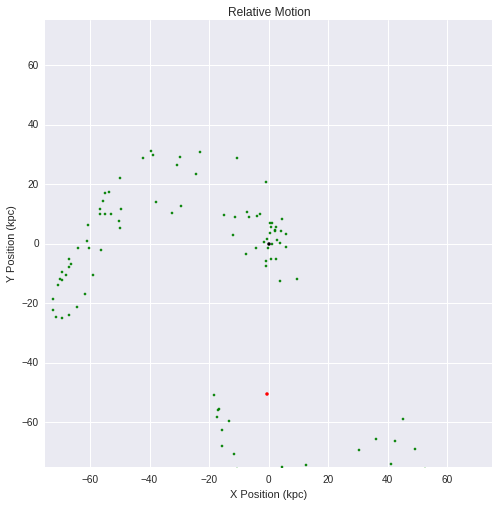

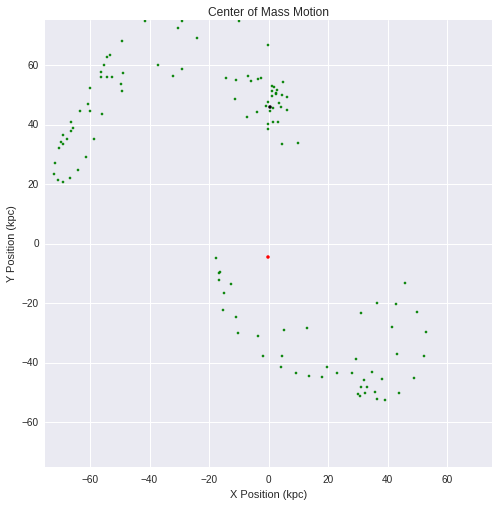

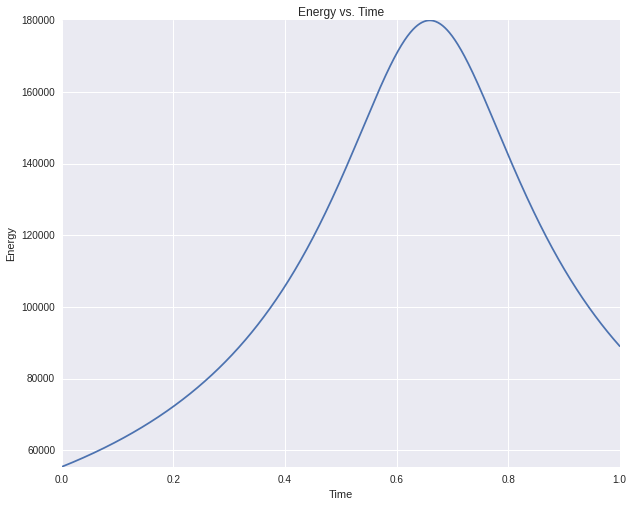

In [13]:
plt.figure(figsize=(10,8))
plt.title("Energy vs. Time")
plt.ylabel("Energy")
plt.xlabel("Time")

E = energy()
plt.ion()
plt.plot(t,E);
plt.ylim(E.min(),E.max());
diff = abs(E.max() - E.min())/abs(E.max())*100
print("The percent difference between maximum energy value and minimum energy value is...")
print(diff)